In [15]:
import pandas as pd
from config import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder


def preprocess_and_split_datasets_stratified(datasets, ignored_features, target_names):
    """
    Preprocesses each dataset by encoding, handling missing values,
    removing ignored features, and splitting into train and test sets with stratification.

    Args:
    datasets (dict): Dictionary of datasets.
    ignored_features (dict): Dictionary of features to ignore for each dataset.
    target_names (dict): Dictionary of target variable names for each dataset.

    Yields:
    tuple: For each dataset, yields (X_train, y_train, X_test, y_test, dataset_name).
    """
    for dataset_name, dataset in datasets.items():
        # Removing ignored features
        features_to_use = [
            feat
            for feat in dataset.columns
            if feat not in ignored_features[dataset_name]
        ]
        data_processed = dataset[features_to_use]

        # Encoding categorical features
        le = LabelEncoder()
        data_processed = data_processed.apply(
            lambda col: le.fit_transform(col) if col.dtype == "object" else col
        )

        # Filling missing values with the median
        data_processed = data_processed.fillna(data_processed.median())

        # Splitting into features and target
        X = data_processed.drop(target_names[dataset_name], axis=1)
        y = data_processed[target_names[dataset_name]]

        # Scaling the data
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        # Splitting the data into train and test sets with a 40-60 split and stratification
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y, test_size=0.6, stratify=y, random_state=42
        )

        yield X_train, y_train, X_test, y_test, dataset_name


# Load the datasets
datasets = {
    # DATA_2_NANME: pd.read_csv(DATA_2_PATH),
    DATA_4_NAME: pd.read_csv(DATA_4_PATH),
    DATA_5_NAME: pd.read_csv(DATA_5_PATH),
    DATA_6_NAME: pd.read_csv(DATA_6_PATH),
}
# Ignored features for each dataset
ignored_features = {
    # DATA_2_NANME: DATA_2_IGNORED_FEAT,
    DATA_4_NAME: DATA_4_IGNORED_FEAT,
    DATA_5_NAME: DATA_5_IGNORED_FEAT,
    DATA_6_NAME: DATA_6_IGNORED_FEAT,
}
# Target variable names for each dataset
target_names = {
    # DATA_2_NANME: DATA_2_TARGET,
    DATA_4_NAME: DATA_4_TARGET,
    DATA_5_NAME: DATA_5_TARGET,
    DATA_6_NAME: DATA_6_TARGET,
}

dataset_splits_stratified = list(
    preprocess_and_split_datasets_stratified(datasets, ignored_features, target_names)
)

# Displaying the shapes of the splits for each dataset as a check
split_shapes_stratified = {
    name: (split[0].shape, split[1].shape, split[2].shape, split[3].shape)
    for name, split in zip(datasets.keys(), dataset_splits_stratified)
}
split_shapes_stratified

{'dataset 4': ((180, 10), (180,), (270, 10), (270,)),
 'dataset 5': ((158, 28), (158,), (237, 28), (237,)),
 'dataset 6': ((128, 8), (128,), (193, 8), (193,))}

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier


def initialize_models():
    """
    Initializes a list of machine learning models for classification.

    Returns:
    A list of model instances.
    """
    models = []

    # ID3 - Decision Tree with entropy criterion
    models.append(DecisionTreeClassifier(criterion="entropy", random_state=42))

    # Logistic Regression
    models.append(LogisticRegression(random_state=42))

    # Random Forest
    models.append(RandomForestClassifier(random_state=42))

    # KNN
    models.append(KNeighborsClassifier())

    # SVM
    models.append(SVC(probability=True, random_state=42))

    # Naive Bayes
    models.append(GaussianNB())

    # Simple ANN
    models.append(MLPClassifier(random_state=42))

    # Rule-Based Model (placeholder - requires specific rules based on the dataset)
    # models.append(CustomRuleBasedModel()) # This is a placeholder

    return models


# Initialize the models
models_list = initialize_models()

# For demonstration, we can display the type of each model in the list
[model.__class__.__name__ for model in models_list]  # Displaying model names

['DecisionTreeClassifier',
 'LogisticRegression',
 'RandomForestClassifier',
 'KNeighborsClassifier',
 'SVC',
 'GaussianNB',
 'MLPClassifier']

In [17]:
from sklearn.ensemble import IsolationForest
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor
from sklearn.cluster import DBSCAN
import numpy as np

def remove_outliers_none(X, y):
    return X, y

def remove_outliers_isolation_forest(X, y):
    # Example implementation, you can adjust parameters
    iso_forest = IsolationForest(contamination=0.1)
    outliers = iso_forest.fit_predict(X)
    return X[outliers == 1], y[outliers == 1]

def remove_outliers_zscore(X, y):
    z_scores = np.abs(stats.zscore(X))
    filtered_entries = (z_scores < 3).all(axis=1)
    return X[filtered_entries], y[filtered_entries]

def remove_outliers_iqr(X, y):
    Q1 = np.percentile(X, 25, axis=0)
    Q3 = np.percentile(X, 75, axis=0)
    IQR = Q3 - Q1
    filtered_entries = ~((X < (Q1 - 1.5 * IQR)) | (X > (Q3 + 1.5 * IQR))).any(axis=1)
    return X[filtered_entries], y[filtered_entries]

def remove_outliers_dbscan(X, y):
    # Example implementation, you can adjust parameters
    dbscan = DBSCAN(eps=0.5, min_samples=5)
    clusters = dbscan.fit_predict(X)
    return X[clusters != -1], y[clusters != -1]

def remove_outliers_lof(X, y):
    # Example implementation, you can adjust parameters
    lof = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
    outliers = lof.fit_predict(X)
    return X[outliers == 1], y[outliers == 1]


In [18]:
from sklearn.feature_selection import SelectFromModel, mutual_info_classif, RFE, VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
import numpy as np

def features_selection_none(X_train, y_train, X_test):
    return X_train, X_test

def features_selection_extratrees(X_train, y_train, X_test):
    model = ExtraTreesClassifier()
    model.fit(X_train, y_train)
    selector = SelectFromModel(model, prefit=True)
    return selector.transform(X_train), selector.transform(X_test)

def features_selection_mutual_information(X_train, y_train, X_test):
    mi = mutual_info_classif(X_train, y_train)
    mi_threshold = np.mean(mi)  # You can choose a different threshold
    high_mi = mi > mi_threshold
    return X_train[:, high_mi], X_test[:, high_mi]

def features_selection_rfe(X_train, y_train, X_test):
    estimator = RandomForestClassifier()
    selector = RFE(estimator, n_features_to_select=5, step=1)  # Adjust the number of features
    selector = selector.fit(X_train, y_train)
    return selector.transform(X_train), selector.transform(X_test)

def features_selection_variance_threshold(X_train, y_train, X_test):
    selector = VarianceThreshold(threshold=(.8 * (1 - .8)))  # Adjust the threshold
    selector.fit(X_train)
    return selector.transform(X_train), selector.transform(X_test)


In [19]:
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

def oversampling_none(X, y):
    return X, y

def oversampling_smote(X, y):
    smote = SMOTE()
    return smote.fit_resample(X, y)

def oversampling_adasyn(X, y):
    adasyn = ADASYN()
    return adasyn.fit_resample(X, y)

def oversampling_smote_borderline(X, y):
    smote_borderline = BorderlineSMOTE()
    return smote_borderline.fit_resample(X, y)

def oversampling_nc_smote(X, y):
    nc_smote = SMOTE()
    return nc_smote.fit_resample(X, y)


In [20]:
import itertools


def generate_configurations():
    remove_outliers_methods = [
        remove_outliers_none,
        remove_outliers_isolation_forest,
        remove_outliers_zscore,
        remove_outliers_iqr,
        remove_outliers_dbscan,
        remove_outliers_lof,
    ]

    feature_selection_methods = [
        features_selection_none,
        features_selection_extratrees,
        features_selection_mutual_information,
        features_selection_rfe,
        features_selection_variance_threshold,
    ]

    oversampling_methods = [
        oversampling_none,
        oversampling_smote,
        # oversampling_svm_smote,
        oversampling_adasyn,
        oversampling_smote_borderline,
        oversampling_nc_smote,
    ]

    for config in itertools.product(
        remove_outliers_methods, feature_selection_methods, oversampling_methods
    ):
        yield config


def apply_configuration(X_train, y_train, X_test, y_test, config):
    remove_outliers_method, feature_selection_method, oversampling_method = config

    # Apply Outlier Removal
    X_train, y_train = remove_outliers_method(X_train, y_train)
    X_test, y_test = remove_outliers_method(
        X_test, y_test
    )  # Assuming the same method applies to test set

    # Apply Feature Selection
    X_train, X_test = feature_selection_method(X_train, y_train, X_test)

    # Apply Oversampling
    X_train, y_train = oversampling_method(X_train, y_train)

    return X_train, y_train, X_test, y_test

In [21]:
from sklearn.metrics import roc_auc_score
import json

def train_evaluate_models(models_list, dataset_splits):
    """
    Trains and evaluates each model on each dataset.

    Args:
    models_list (list): List of initialized machine learning models.
    dataset_splits (list): List of tuples containing (X_train, y_train, X_test, y_test) for each dataset.

    Returns:
    dict: A dictionary containing evaluation results for each model on each dataset.
    """
    results = {}

    for model in models_list:
        model_name = model.__class__.__name__
        results[model_name] = {}
        print(model_name)
        for X_train, y_train, X_test, y_test, dataset_name in dataset_splits:
            results[model_name][dataset_name] = {}
            print(dataset_name)
            for config in generate_configurations():
                config_name = (
                    config[0].__name__
                    + "/"
                    + config[1].__name__
                    + "/"
                    + config[2].__name__
                )
                print(config_name)
                try:
                    X_train, y_train, X_test, y_test = apply_configuration(X_train, y_train, X_test, y_test, config)
                    # Train the model
                    model.fit(X_train, y_train)

                    # Evaluate on the training set
                    y_train_pred = model.predict_proba(X_train)[:, 1]
                    train_roc_auc = roc_auc_score(y_train, y_train_pred)

                    # Evaluate on the test set
                    y_test_pred = model.predict_proba(X_test)[:, 1]
                    test_roc_auc = roc_auc_score(y_test, y_test_pred)

                    # Check for overfitting
                    overfitting = "Yes" if train_roc_auc > test_roc_auc else "No"

                    # Store the results
                    results[model_name][dataset_name][config_name] = {
                        "Train ROC-AUC": train_roc_auc,
                        "Test ROC-AUC": test_roc_auc,
                        "Overfitting": overfitting,
                    }
                except ValueError:
                    print("Error")
                    continue
    return results

# Using the method and saving results to JSON
evaluation_results = train_evaluate_models(models_list, dataset_splits_stratified)

results_output_path = 'results/final_results.json'
with open(results_output_path, 'w') as file:
    json.dump(evaluation_results, file, indent=4)
print(f"Results saved to {results_output_path}")

DecisionTreeClassifier
dataset 4
remove_outliers_none/features_selection_none/oversampling_none
remove_outliers_none/features_selection_none/oversampling_smote
remove_outliers_none/features_selection_none/oversampling_adasyn
remove_outliers_none/features_selection_none/oversampling_smote_borderline
remove_outliers_none/features_selection_none/oversampling_nc_smote
remove_outliers_none/features_selection_extratrees/oversampling_none
remove_outliers_none/features_selection_extratrees/oversampling_smote
remove_outliers_none/features_selection_extratrees/oversampling_adasyn
remove_outliers_none/features_selection_extratrees/oversampling_smote_borderline
remove_outliers_none/features_selection_extratrees/oversampling_nc_smote
remove_outliers_none/features_selection_mutual_information/oversampling_none
Error
remove_outliers_none/features_selection_mutual_information/oversampling_smote
Error
remove_outliers_none/features_selection_mutual_information/oversampling_adasyn
Error
remove_outliers_n

c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_none/oversampling_adasyn
remove_outliers_none/features_selection_none/oversampling_smote_borderline


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_none/oversampling_nc_smote
remove_outliers_none/features_selection_extratrees/oversampling_none


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_extratrees/oversampling_smote


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_extratrees/oversampling_adasyn
remove_outliers_none/features_selection_extratrees/oversampling_smote_borderline
remove_outliers_none/features_selection_extratrees/oversampling_nc_smote
remove_outliers_none/features_selection_mutual_information/oversampling_none
Error
remove_outliers_none/features_selection_mutual_information/oversampling_smote
Error
remove_outliers_none/features_selection_mutual_information/oversampling_adasyn
Error
remove_outliers_none/features_selection_mutual_information/oversampling_smote_borderline
Error
remove_outliers_none/features_selection_mutual_information/oversampling_nc_smote
Error
remove_outliers_none/features_selection_rfe/oversampling_none
Error
remove_outliers_none/features_selection_rfe/oversampling_smote
Error
remove_outliers_none/features_selection_rfe/oversampling_adasyn
Error
remove_outliers_none/features_selection_rfe/oversampling_smote_borderline
Error
remove_outliers_none/features_selection_rfe/oversampli

c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_none/oversampling_smote


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_none/oversampling_adasyn
remove_outliers_none/features_selection_none/oversampling_smote_borderline


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_none/oversampling_nc_smote


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_extratrees/oversampling_none


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_extratrees/oversampling_smote


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_extratrees/oversampling_adasyn
remove_outliers_none/features_selection_extratrees/oversampling_smote_borderline
remove_outliers_none/features_selection_extratrees/oversampling_nc_smote
remove_outliers_none/features_selection_mutual_information/oversampling_none
Error
remove_outliers_none/features_selection_mutual_information/oversampling_smote
Error
remove_outliers_none/features_selection_mutual_information/oversampling_adasyn
Error
remove_outliers_none/features_selection_mutual_information/oversampling_smote_borderline
Error
remove_outliers_none/features_selection_mutual_information/oversampling_nc_smote
Error
remove_outliers_none/features_selection_rfe/oversampling_none
Error
remove_outliers_none/features_selection_rfe/oversampling_smote
Error
remove_outliers_none/features_selection_rfe/oversampling_adasyn
Error
remove_outliers_none/features_selection_rfe/oversampling_smote_borderline
Error
remove_outliers_none/features_selection_rfe/oversampli

c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_none/oversampling_adasyn
remove_outliers_none/features_selection_none/oversampling_smote_borderline


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_none/oversampling_nc_smote
remove_outliers_none/features_selection_extratrees/oversampling_none


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_extratrees/oversampling_smote


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_extratrees/oversampling_adasyn


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_extratrees/oversampling_smote_borderline


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_extratrees/oversampling_nc_smote
remove_outliers_none/features_selection_mutual_information/oversampling_none
Error
remove_outliers_none/features_selection_mutual_information/oversampling_smote
Error
remove_outliers_none/features_selection_mutual_information/oversampling_adasyn
Error
remove_outliers_none/features_selection_mutual_information/oversampling_smote_borderline
Error
remove_outliers_none/features_selection_mutual_information/oversampling_nc_smote
Error
remove_outliers_none/features_selection_rfe/oversampling_none
Error
remove_outliers_none/features_selection_rfe/oversampling_smote
Error
remove_outliers_none/features_selection_rfe/oversampling_adasyn
Error
remove_outliers_none/features_selection_rfe/oversampling_smote_borderline
Error
remove_outliers_none/features_selection_rfe/oversampling_nc_smote
Error
remove_outliers_none/features_selection_variance_threshold/oversampling_none
Error
remove_outliers_none/features_selection_variance_th

c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


DecisionTreeClassifier
dataset 4
remove_outliers_none/features_selection_none/oversampling_none
remove_outliers_none/features_selection_none/oversampling_smote
remove_outliers_none/features_selection_none/oversampling_adasyn
remove_outliers_none/features_selection_none/oversampling_smote_borderline
remove_outliers_none/features_selection_none/oversampling_nc_smote
remove_outliers_none/features_selection_extratrees/oversampling_none
remove_outliers_none/features_selection_extratrees/oversampling_smote
remove_outliers_none/features_selection_extratrees/oversampling_adasyn
remove_outliers_none/features_selection_extratrees/oversampling_smote_borderline
remove_outliers_none/features_selection_extratrees/oversampling_nc_smote
remove_outliers_none/features_selection_mutual_information/oversampling_none
Error
remove_outliers_none/features_selection_mutual_information/oversampling_smote
Error
remove_outliers_none/features_selection_mutual_information/oversampling_adasyn
Error
remove_outliers_n

c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_none/oversampling_smote
remove_outliers_none/features_selection_none/oversampling_adasyn


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_none/oversampling_smote_borderline
remove_outliers_none/features_selection_none/oversampling_nc_smote


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_extratrees/oversampling_none


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_extratrees/oversampling_smote


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_extratrees/oversampling_adasyn
remove_outliers_none/features_selection_extratrees/oversampling_smote_borderline
remove_outliers_none/features_selection_extratrees/oversampling_nc_smote
remove_outliers_none/features_selection_mutual_information/oversampling_none
Error
remove_outliers_none/features_selection_mutual_information/oversampling_smote
Error
remove_outliers_none/features_selection_mutual_information/oversampling_adasyn
Error
remove_outliers_none/features_selection_mutual_information/oversampling_smote_borderline
Error
remove_outliers_none/features_selection_mutual_information/oversampling_nc_smote
Error
remove_outliers_none/features_selection_rfe/oversampling_none
Error
remove_outliers_none/features_selection_rfe/oversampling_smote
Error
remove_outliers_none/features_selection_rfe/oversampling_adasyn
Error
remove_outliers_none/features_selection_rfe/oversampling_smote_borderline
Error
remove_outliers_none/features_selection_rfe/oversampli

c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_none/oversampling_smote


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_none/oversampling_adasyn


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_none/oversampling_smote_borderline
remove_outliers_none/features_selection_none/oversampling_nc_smote


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_extratrees/oversampling_none


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_extratrees/oversampling_smote


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_extratrees/oversampling_adasyn


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_extratrees/oversampling_smote_borderline
remove_outliers_none/features_selection_extratrees/oversampling_nc_smote
remove_outliers_none/features_selection_mutual_information/oversampling_none
Error
remove_outliers_none/features_selection_mutual_information/oversampling_smote
Error
remove_outliers_none/features_selection_mutual_information/oversampling_adasyn
Error
remove_outliers_none/features_selection_mutual_information/oversampling_smote_borderline
Error
remove_outliers_none/features_selection_mutual_information/oversampling_nc_smote
Error
remove_outliers_none/features_selection_rfe/oversampling_none
Error
remove_outliers_none/features_selection_rfe/oversampling_smote
Error
remove_outliers_none/features_selection_rfe/oversampling_adasyn
Error
remove_outliers_none/features_selection_rfe/oversampling_smote_borderline
Error
remove_outliers_none/features_selection_rfe/oversampling_nc_smote
Error
remove_outliers_none/features_selection_variance_thre

c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_none/oversampling_adasyn


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_none/oversampling_smote_borderline
remove_outliers_none/features_selection_none/oversampling_nc_smote


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_extratrees/oversampling_none


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_extratrees/oversampling_smote


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_extratrees/oversampling_adasyn


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_extratrees/oversampling_smote_borderline


c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


remove_outliers_none/features_selection_extratrees/oversampling_nc_smote
remove_outliers_none/features_selection_mutual_information/oversampling_none
Error
remove_outliers_none/features_selection_mutual_information/oversampling_smote
Error
remove_outliers_none/features_selection_mutual_information/oversampling_adasyn
Error
remove_outliers_none/features_selection_mutual_information/oversampling_smote_borderline
Error
remove_outliers_none/features_selection_mutual_information/oversampling_nc_smote
Error
remove_outliers_none/features_selection_rfe/oversampling_none
Error
remove_outliers_none/features_selection_rfe/oversampling_smote
Error
remove_outliers_none/features_selection_rfe/oversampling_adasyn
Error
remove_outliers_none/features_selection_rfe/oversampling_smote_borderline
Error
remove_outliers_none/features_selection_rfe/oversampling_nc_smote
Error
remove_outliers_none/features_selection_variance_threshold/oversampling_none
Error
remove_outliers_none/features_selection_variance_th

c:\Users\jorge\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


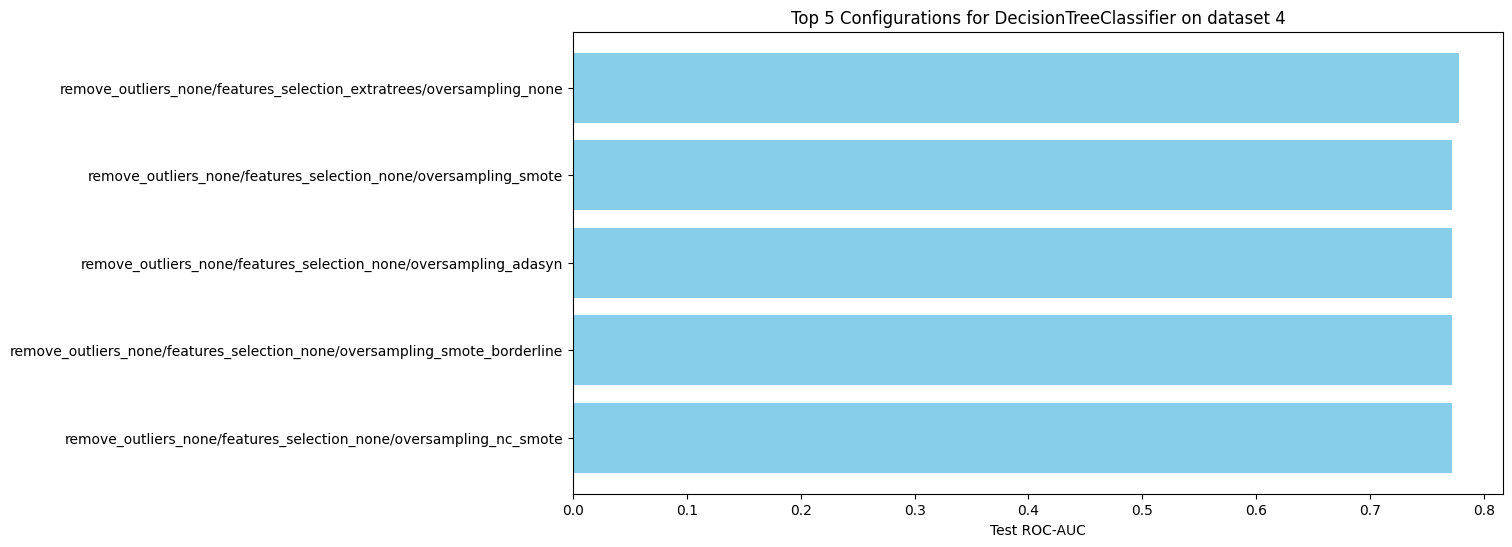

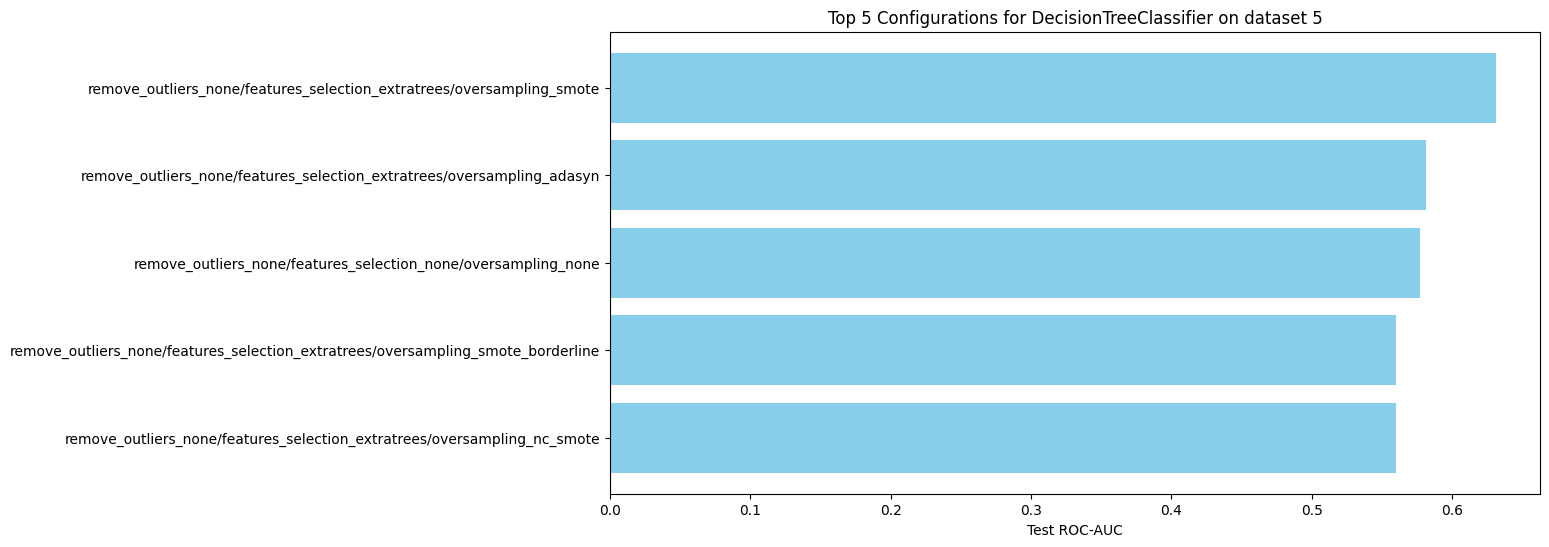

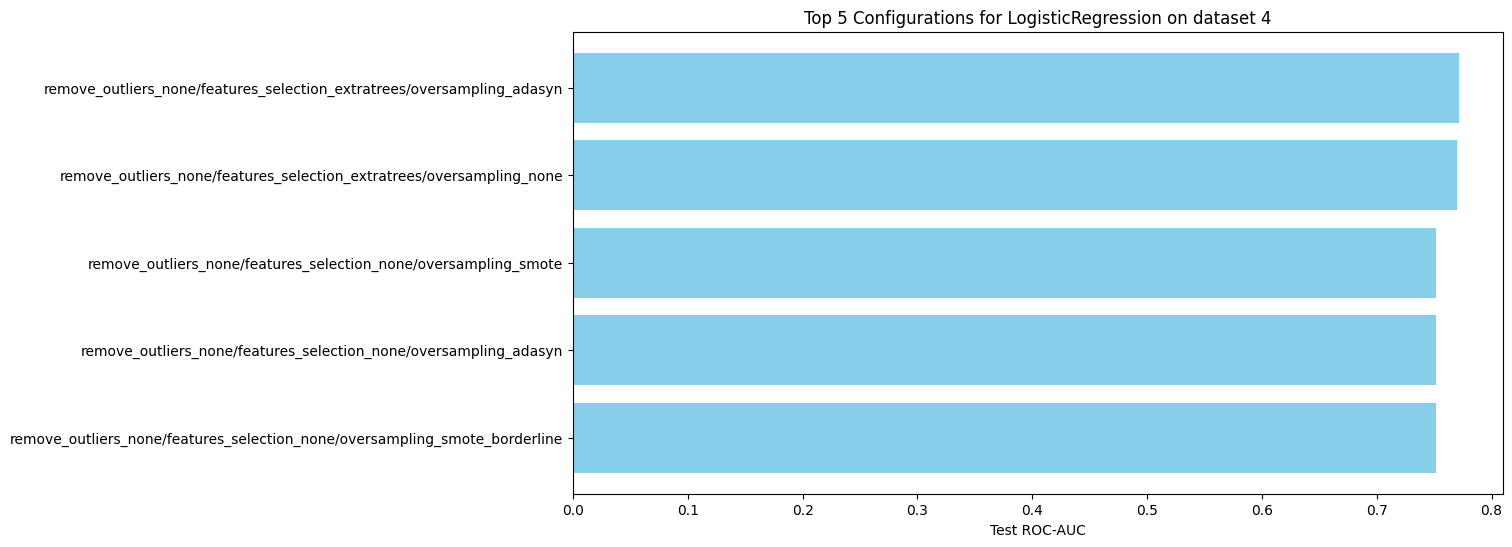

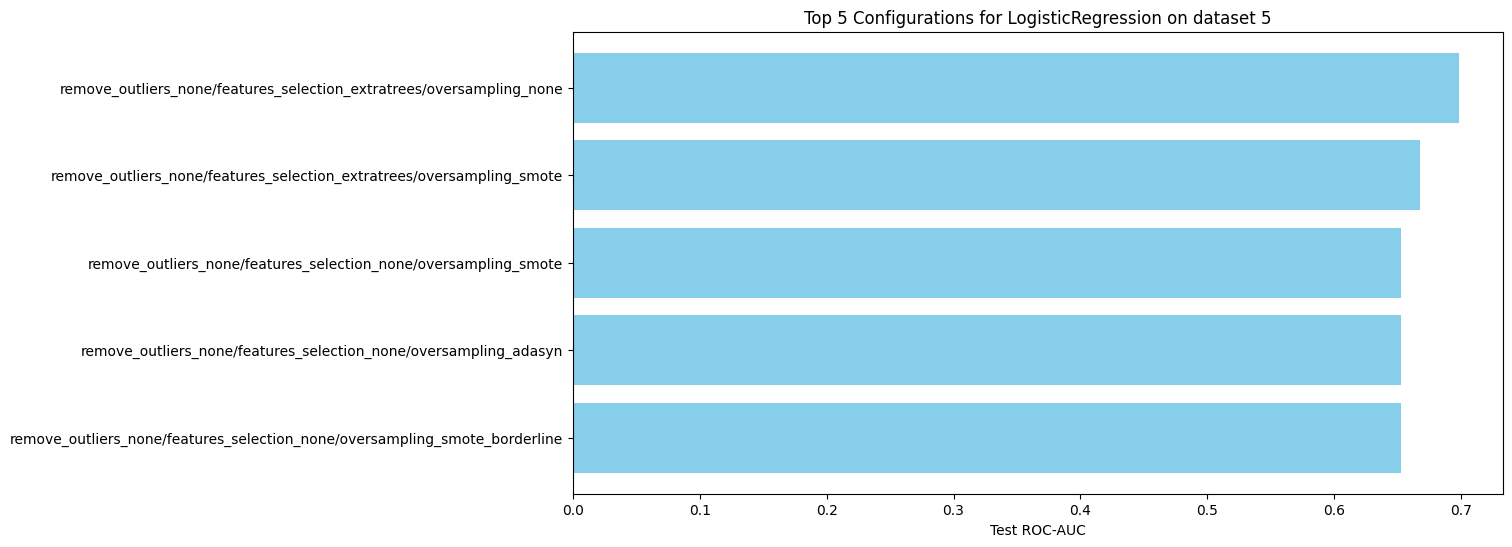

In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import json

with open(results_output_path, "r") as file:
    results = json.load(file)


def plot_top_configurations(results, model_name, dataset_name, top_n=5):
    # Extracting results for the specified model and dataset
    model_results = results.get(model_name, {})
    dataset_results = model_results.get(dataset_name, {})

    # Convert to DataFrame for easy sorting and manipulation
    df = pd.DataFrame(dataset_results).T
    df["Configuration"] = df.index
    df.sort_values(by="Test ROC-AUC", ascending=False, inplace=True)

    # Select top N configurations
    top_configs = df.head(top_n)

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.barh(top_configs["Configuration"], top_configs["Test ROC-AUC"], color="skyblue")
    plt.xlabel("Test ROC-AUC")
    plt.title(f"Top {top_n} Configurations for {model_name} on {dataset_name}")
    plt.gca().invert_yaxis()  # To display the highest score at the top
    plt.show()


# Extract model and dataset names for plotting
model_names = list(results.keys())
dataset_names = list(results[model_names[0]].keys())

# Plotting top configurations for the first few model-dataset combinations
for model_name in model_names[:2]:  # Limiting to first two models for demonstration
    for dataset_name in dataset_names[
        :2
    ]:  # Limiting to first two datasets for demonstration
        plot_top_configurations(results, model_name, dataset_name)

In [ ]:
from scipy.stats import friedmanchisquare
import scikit_posthocs as sp
import numpy as np

# Assuming 'data' is a pandas DataFrame where each column is a model and each row is a dataset

# Friedman Test
friedman_stat, friedman_p = friedmanchisquare(*[data[col] for col in data.columns])
print("Friedman Test statistic:", friedman_stat)
print("Friedman Test p-value:", friedman_p)

# If Friedman test is significant, proceed with Nemenyi Test
if friedman_p < 0.05:
    nemenyi = sp.posthoc_nemenyi_friedman(data)
    print("Nemenyi Test Results:\n", nemenyi)
else:
    print("No significant differences found by Friedman Test.")